In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
np.random.seed(0)
def generate_data(num_samples):
    X = np.zeros((num_samples, 4))
    X[3] = np.random.uniform(0, 0.1, 4)
    for i in range(4, num_samples):
        X[i] = 0.6 * X[i-1] + (-0.5) * X[i-2] + (-0.2) * X[i-3] + np.random.uniform(0, 0.1)
    return X

train_data = generate_data(2000)
test_data = generate_data(2000)

In [5]:
def prepare_data(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

seq_length = 10
train_X, train_y = prepare_data(train_data, seq_length)
test_X, test_y = prepare_data(test_data, seq_length)

train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float())
test_dataset = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float())

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

1 Layer

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 4
hidden_size = 32
num_layers = 1

model = RNN(input_size, hidden_size, num_layers)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        #targets = np.reshape(targets, (-1,))
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))

            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/hrithiksagar/miniforge3/envs/plants_venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 4])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/hrithiksagar/miniforge3/envs/plants_venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 1, 4])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:10<00:00,  9.13it/s]


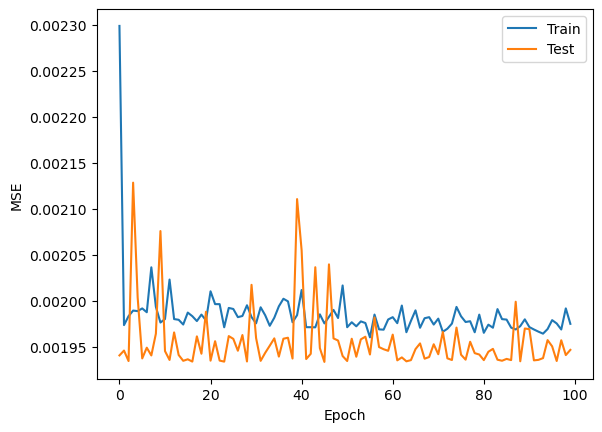

In [8]:
plt.plot(range(num_epochs), train_losses, label='Train')
plt.plot(range(num_epochs), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [9]:
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for inputs, targets_batch in test_loader:
        inputs = inputs.to(device)
        targets_batch = targets_batch.to(device)
        outputs = model(inputs)

        last_predictions = outputs[:, -1] # Assuming outputs is of shape (batch_size, sequence_length, output_dim), This works for any output_dim, Extract the last predictions from each sequence. 
        
        predictions.extend(last_predictions.cpu().numpy())
        targets.extend(targets_batch.cpu().numpy())

predictions = np.array(predictions)
predictions = predictions.reshape(-1, 1)

targets = np.array(targets)
mse = np.mean((predictions - targets) ** 2)
mae = np.mean(np.abs(predictions - targets))
ssr = np.sum((targets - predictions) ** 2)
sst = np.sum((targets - np.mean(targets)) ** 2)
r2 = 1 - (ssr / sst)

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 0.001885858
MAE: 0.035379335
R2: 0.02441728115081787


2 Layers

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
input_size = 4
hidden_size = 32
num_layers = 2
model = RNN(input_size, hidden_size, num_layers)
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for inputs, targets_batch in test_loader:
        inputs = inputs.to(device)
        targets_batch = targets_batch.to(device)
        outputs = model(inputs)

        last_predictions = outputs[:, -1]  # Assuming outputs is of shape (batch_size, sequence_length, output_dim), This works for any output_dim, Extract the last predictions from each sequence
        
        predictions.extend(last_predictions.cpu().numpy())
        targets.extend(targets_batch.cpu().numpy())

predictions = np.array(predictions)
predictions = predictions.reshape(-1, 1)

targets = np.array(targets)

mse = np.mean((predictions - targets) ** 2)
mae = np.mean(np.abs(predictions - targets))
ssr = np.sum((targets - predictions) ** 2)
sst = np.sum((targets - np.mean(targets)) ** 2)
r2 = 1 - (ssr / sst)

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 0.08396036
MAE: 0.28688037
R2: -42.433956146240234


3 Layers

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 4
hidden_size = 32
num_layers = 3

model = RNN(input_size, hidden_size, num_layers)


model.eval()
predictions = []
targets = []

with torch.no_grad():
    for inputs, targets_batch in test_loader:
        inputs = inputs.to(device)
        targets_batch = targets_batch.to(device)
        outputs = model(inputs)

        last_predictions = outputs[:, -1]  # Assuming outputs is of shape (batch_size, sequence_length, output_dim), This works for any output_dim, Extract the last predictions from each sequence.
        
        predictions.extend(last_predictions.cpu().numpy())
        targets.extend(targets_batch.cpu().numpy())

predictions = np.array(predictions)
predictions = predictions.reshape(-1, 1)

targets = np.array(targets)
mse = np.mean((predictions - targets) ** 2)
mae = np.mean(np.abs(predictions - targets))
ssr = np.sum((targets - predictions) ** 2)
sst = np.sum((targets - np.mean(targets)) ** 2)
r2 = 1 - (ssr / sst)

print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 0.0059285876
MAE: 0.06547623
R2: -2.0669476985931396


# Question 2

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Parameters
p = 100
sequence_length = p + 1
num_training_sequences = 1000
num_test_sequences = 3000
num_trials = 10

In [18]:
# Generate random sequences for training and test sets
def generate_sequence():
    return np.random.randint(1, p, size=p - 1)

def generate_training_data():
    training_data = []
    for _ in range(num_training_sequences):
        if np.random.random() < 0.5:
            sequence = [0] + list(generate_sequence()) + [0]
            #print(sequence)
        else:
            sequence = [p] + list(generate_sequence()) + [p]
            #print(sequence)
        training_data.append(sequence)
    return np.array(training_data)

# generate_training_data()

In [19]:
def generate_test_data():
    test_data = []
    for _ in range(num_test_sequences):
        if np.random.random() < 0.5:
            sequence = [0] + list(generate_sequence()) + [0]
        else:
            sequence = [p] + list(generate_sequence()) + [p]
        test_data.append(sequence)
    return np.array(test_data)

In [20]:
training_data = generate_training_data()
test_data = generate_test_data()

In [21]:
# Define RNN
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [22]:
#LSTM
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [23]:
# Training loop
def train_model(model, training_data, num_epochs=100, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []

    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        for sequence in training_data:
            sequence = torch.from_numpy(sequence).float().unsqueeze(0).unsqueeze(2).to(device)
            inputs, targets = sequence[:, :-1, :], sequence[:, 1:, :]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        train_losses.append(total_loss / len(training_data))

    return train_losses

In [24]:
# Test loop
def test_model(model, test_data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    num_wrong_predictions = 0

    for sequence in test_data:
        sequence = torch.from_numpy(sequence).float().unsqueeze(0).unsqueeze(2).to(device)
        inputs, targets = sequence[:, :-1, :], sequence[:, 1:, :]
        outputs = model(inputs)
        predictions = torch.round(outputs)
        num_wrong_predictions += torch.sum(torch.abs(predictions - targets)).item()

    return num_wrong_predictions

In [25]:
# Train and evaluate RNN and LSTM
num_epochs = 100
learning_rate = 0.001

rnn_model = RNN()
lstm_model = LSTM()

rnn_train_losses = train_model(rnn_model, training_data, num_epochs, learning_rate)
lstm_train_losses = train_model(lstm_model, training_data, num_epochs, learning_rate)

100%|██████████| 100/100 [25:34<00:00, 15.35s/it]


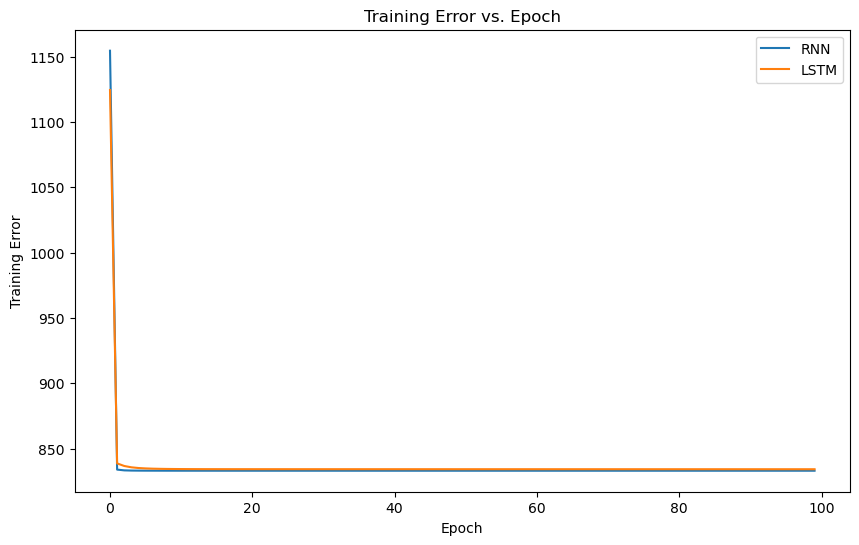

Average number of wrong predictions for RNN: 7501329.0
Average number of wrong predictions for LSTM: 7505337.0


In [26]:
# Plot training errors
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), rnn_train_losses, label='RNN')
plt.plot(range(num_epochs), lstm_train_losses, label='LSTM')
plt.xlabel('Epoch')
plt.ylabel('Training Error')
plt.legend()
plt.title('Training Error vs. Epoch')
plt.show()

# Test models and report average number of wrong predictions
rnn_wrong_predictions = 0
lstm_wrong_predictions = 0

for _ in range(num_trials):
    rnn_wrong_predictions += test_model(rnn_model, test_data)
    lstm_wrong_predictions += test_model(lstm_model, test_data)

avg_rnn_wrong_predictions = rnn_wrong_predictions / num_trials
avg_lstm_wrong_predictions = lstm_wrong_predictions / num_trials

print('Average number of wrong predictions for RNN:', avg_rnn_wrong_predictions)
print('Average number of wrong predictions for LSTM:', avg_lstm_wrong_predictions)

RNN model performs slightly better than the LSTM model.
Difference in performance between the two models is relatively small, and both models seem to have a relatively high number of wrong predictions. These differences in performance may not always be significant. 
